## Import data

In [1]:
# !pip install iterative-stratification

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from scipy.stats import skew 
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train_quantitative = pd.read_excel('/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx')
train_categorical = pd.read_excel('/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx')
train_mri = pd.read_csv('/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')
train_labels = pd.read_excel('/kaggle/input/widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx')

In [3]:
test_quantitative = pd.read_excel('/kaggle/input/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx')
test_categorical = pd.read_excel('/kaggle/input/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx')
test_mri = pd.read_csv('/kaggle/input/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv')

In [4]:
train_data_frames = [train_mri, train_categorical, train_quantitative, train_labels]
test_data_frames = [test_quantitative, test_categorical, test_mri]
train_df = reduce(lambda  left,right: pd.merge(left,right,on=['participant_id'],
                                            how='outer'), train_data_frames)
test_df = reduce(lambda  left,right: pd.merge(left,right,on=['participant_id'],
                                            how='outer'), test_data_frames)

quant_columns = train_quantitative.columns[1:].tolist()
cat_columns = train_categorical.columns[1:].tolist()


In [5]:
train_df.describe()

,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,0throw_10thcolumn,...,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan,ADHD_Outcome,Sex_F
count,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,...,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,853.000000,1213.000000,1213.000000
mean,0.185265,0.583053,0.439351,0.450398,0.584654,0.554164,0.508957,0.282565,0.426095,0.254628,...,2.324751,7.613787,4.103821,5.539037,4.599668,2.274917,7.740864,11.245678,0.685078,0.342951
std,0.238481,0.172632,0.235019,0.212111,0.195918,0.157533,0.179127,0.189683,0.202979,0.208395,...,2.166399,4.130399,2.808079,2.807063,3.510469,2.089041,2.094832,3.234372,0.464676,0.474891
min,-0.657053,-0.224815,-0.517318,-0.440235,-0.486239,-0.059139,-0.181009,-0.341516,-0.353362,-0.578757,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.028235,0.495514,0.286137,0.314428,0.486735,0.462448,0.406548,0.152607,0.319183,0.124448,...,1.000000,5.000000,2.000000,4.000000,2.000000,0.000000,6.000000,8.803901,0.000000,0.000000
50%,0.192886,0.606585,0.469826,0.479330,0.623346,0.577187,0.534237,0.290552,0.452538,0.268802,...,2.000000,8.000000,4.000000,6.000000,4.000000,2.000000,8.000000,10.739219,1.000000,0.000000
75%,0.358902,0.710758,0.626871,0.604438,0.726116,0.670072,0.636448,0.423821,0.570470,0.402742,...,4.000000,10.000000,6.000000,8.000000,7.000000,4.000000,10.000000,13.460871,1.000000,1.000000
max,0.824448,0.907209,0.884576,0.876987,0.893974,0.882400,0.892983,0.803253,0.854104,0.828335,...,10.000000,20.000000,10.000000,10.000000,17.000000,9.000000,10.000000,21.564453,1.000000,1.000000


## Data Preprocessing

### 1. Missing Data Handling

In [6]:
missing_values_summ = train_df.isna().sum().reset_index()
missing_values_summ.columns = ['variable', 'count']
missing_values_summ.query('count>0')

,variable,count
19903,PreInt_Demos_Fam_Child_Ethnicity,43
19904,PreInt_Demos_Fam_Child_Race,54
19905,MRI_Track_Scan_Location,3
19906,Barratt_Barratt_P1_Edu,15
19907,Barratt_Barratt_P1_Occ,31
19908,Barratt_Barratt_P2_Edu,198
19909,Barratt_Barratt_P2_Occ,222
19910,EHQ_EHQ_Total,13
19911,ColorVision_CV_Score,23
19912,APQ_P_APQ_P_CP,12


Fill NAs with means

In [8]:
def fill_na(train_df, test_df):
    train_df.fillna({'MRI_Track_Age_at_Scan':train_df['MRI_Track_Age_at_Scan'].mean()}, inplace = True)
    # PreInt_Demos_Fam_Child_Ethnicity 3 = unknown
    train_df.fillna({'PreInt_Demos_Fam_Child_Ethnicity': 3}, inplace = True)
    
    print(train_df.isna().sum().sum()) # should now be zero
    
    for col in test_df.columns:
        if test_df[col].isna().sum() > 0:  # Check if the column has NaN values
            if col in quant_columns:  # Ensure it's numeric
                test_df[col] = test_df[col].fillna(test_df[col].mean())  # Avoid inplace
            else:
                print(f"Skipping non-numeric column: {col}")
            if col in cat_columns:
                if col == 'PreInt_Demos_Fam_Child_Ethnicity':
                    test_df[col] = test_df[col].fillna(3)  # Avoid inplace
                else:
                    test_df[col] = test_df[col].fillna(-1)
    return train_df, test_df

                
# for categorical values 
# PreInt_Demos_Fam_Child_Ethnicity, unknown = 3
# PreInt_Demos_Fam_Child_Race set as unknown = -1       
# Barratt_Barratt_P1_Edu unknown = -1
# Barratt_Barratt_P1_Occ unknown = -1
# Barratt_Barratt_P2_Edu unknown = -1
# Barratt_Barratt_P2_Occ unknown = -1

Fill NAs for test df

In [9]:
missing_data = test_df.isna().sum().reset_index() 
missing_data.columns = ['variable', 'value']
missing_data.query('value!=0').sort_values(by = 'value', ascending = False)

,variable,value
27,Barratt_Barratt_P2_Occ,42
26,Barratt_Barratt_P2_Edu,36
10,SDQ_SDQ_Difficulties_Total,30
17,SDQ_SDQ_Prosocial,30
16,SDQ_SDQ_Peer_Problems,30
15,SDQ_SDQ_Internalizing,30
14,SDQ_SDQ_Hyperactivity,30
13,SDQ_SDQ_Generating_Impact,30
11,SDQ_SDQ_Emotional_Problems,30
12,SDQ_SDQ_Externalizing,30


### 2. Quant features

In [10]:
train_quantitative.columns

Index(['participant_id', 'EHQ_EHQ_Total', 'ColorVision_CV_Score',
       'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV',
       'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP',
       'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total',
       'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing',
       'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity',
       'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial',
       'MRI_Track_Age_at_Scan'],
      dtype='object')

In [11]:
train_quantitative.describe()

,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
count,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,853.000000
mean,58.876917,13.164880,3.781533,13.205276,39.374279,17.785655,16.393240,25.246496,2.059357,12.122836,2.307502,7.557296,4.073372,5.497939,4.565540,2.258038,7.683430,11.245678
std,49.855501,2.780624,1.376700,3.811772,6.245928,3.764112,5.376994,3.950529,2.023322,6.577207,2.167549,4.166627,2.819731,2.836764,3.519634,2.090414,2.190295,3.234372
min,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.600000,14.000000,3.000000,11.000000,36.000000,16.000000,13.000000,23.000000,0.000000,7.000000,1.000000,4.000000,2.000000,4.000000,2.000000,0.000000,6.000000,8.803901
50%,76.670000,14.000000,3.000000,13.000000,40.000000,18.000000,16.000000,26.000000,2.000000,12.000000,2.000000,7.000000,4.000000,6.000000,4.000000,2.000000,8.000000,10.739219
75%,93.400000,14.000000,4.000000,16.000000,43.000000,20.000000,19.000000,28.000000,3.000000,17.000000,4.000000,10.000000,6.000000,8.000000,7.000000,4.000000,10.000000,13.460871
max,100.000000,14.000000,12.000000,28.000000,50.000000,28.000000,37.000000,30.000000,10.000000,34.000000,10.000000,20.000000,10.000000,10.000000,17.000000,9.000000,10.000000,21.564453


<Figure size 20000x60000 with 0 Axes>

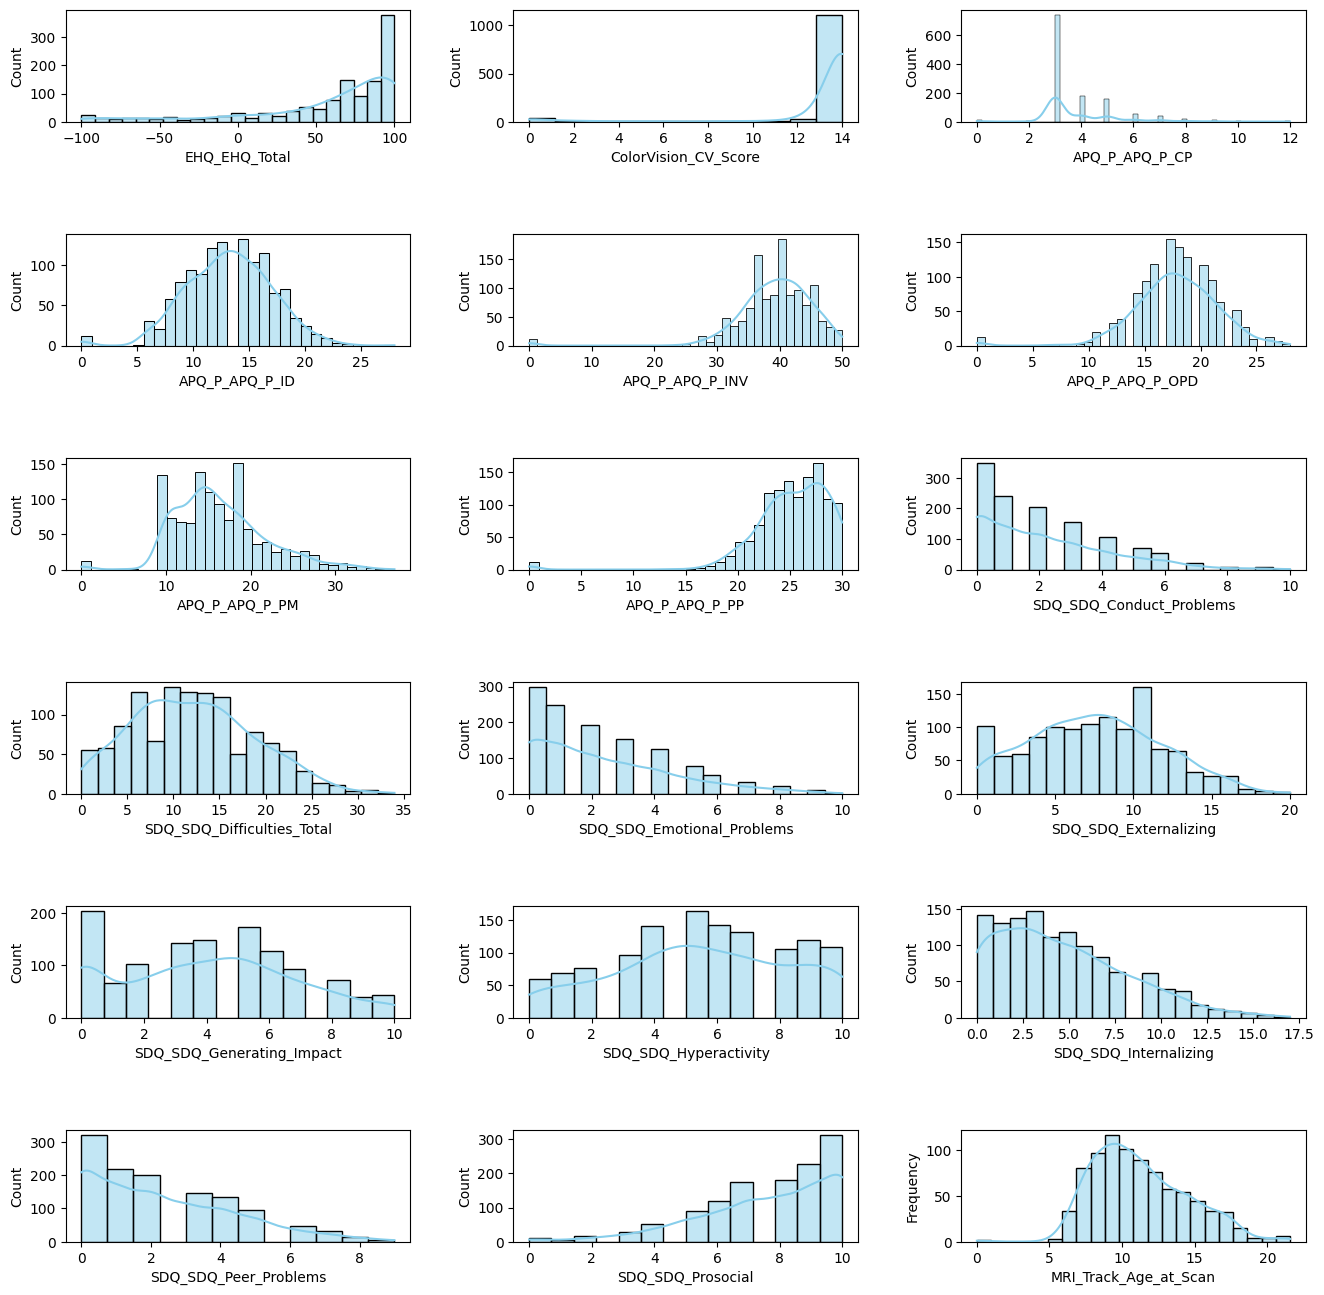

In [12]:
plt.figure(figsize=(200, 600)) 

fig, axes = plt.subplots(6, 3, figsize=(16, 16))
plt.subplots_adjust(hspace=1, wspace=0.3)
i = 0
for col in train_quantitative.columns[1:]:
    x = i // 3
    y = i % 3
    sns.histplot(train_df[col], kde=True, color='skyblue', ax=axes[x, y])
    plt.xlabel(col)
    plt.ylabel('Frequency')
    i+=1
    

In [66]:
['APQ_P_APQ_P_CP', 'APQ_P_APQ_P_PM', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'MRI_Track_Age_at_Scan']

['APQ_P_APQ_P_CP',
 'APQ_P_APQ_P_PM',
 'SDQ_SDQ_Conduct_Problems',
 'SDQ_SDQ_Difficulties_Total',
 'SDQ_SDQ_Emotional_Problems',
 'SDQ_SDQ_Externalizing',
 'SDQ_SDQ_Generating_Impact',
 'SDQ_SDQ_Internalizing',
 'SDQ_SDQ_Peer_Problems',
 'MRI_Track_Age_at_Scan']

1) Log transform right skewed features
2) Standard scale 

In [18]:
# skewed_cols = ['EHQ_EHQ_Total','SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial',
#               'SDQ_SDQ_Internalizing','SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Conduct_Problems',
#               'EHQ_EHQ_Total', 'APQ_P_APQ_P_PP', 'APQ_P_APQ_P_INV']

### 3. Categorical features


In [13]:
train_categorical.columns

Index(['participant_id', 'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ'],
      dtype='object')

Count the distinct values of each category

In [14]:
categorical_summ = {}

for col in list(train_categorical.columns):
    categorical_summ[col] = train_df[col].nunique()

categorical_summ 

{'participant_id': 1213,
 'Basic_Demos_Enroll_Year': 6,
 'Basic_Demos_Study_Site': 4,
 'PreInt_Demos_Fam_Child_Ethnicity': 4,
 'PreInt_Demos_Fam_Child_Race': 10,
 'MRI_Track_Scan_Location': 5,
 'Barratt_Barratt_P1_Edu': 8,
 'Barratt_Barratt_P1_Occ': 10,
 'Barratt_Barratt_P2_Edu': 8,
 'Barratt_Barratt_P2_Occ': 10}

In [15]:
train_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   participant_id                    1213 non-null   object 
 1   Basic_Demos_Enroll_Year           1213 non-null   int64  
 2   Basic_Demos_Study_Site            1213 non-null   int64  
 3   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64
 4   PreInt_Demos_Fam_Child_Race       1213 non-null   int64  
 5   MRI_Track_Scan_Location           1213 non-null   int64  
 6   Barratt_Barratt_P1_Edu            1213 non-null   int64  
 7   Barratt_Barratt_P1_Occ            1213 non-null   int64  
 8   Barratt_Barratt_P2_Edu            1213 non-null   int64  
 9   Barratt_Barratt_P2_Occ            1213 non-null   int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 94.9+ KB


In [16]:
test_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   participant_id                    304 non-null    object 
 1   Basic_Demos_Enroll_Year           304 non-null    int64  
 2   Basic_Demos_Study_Site            304 non-null    int64  
 3   PreInt_Demos_Fam_Child_Ethnicity  301 non-null    float64
 4   PreInt_Demos_Fam_Child_Race       298 non-null    float64
 5   MRI_Track_Scan_Location           304 non-null    int64  
 6   Barratt_Barratt_P1_Edu            303 non-null    float64
 7   Barratt_Barratt_P1_Occ            303 non-null    float64
 8   Barratt_Barratt_P2_Edu            268 non-null    float64
 9   Barratt_Barratt_P2_Occ            262 non-null    float64
dtypes: float64(6), int64(3), object(1)
memory usage: 23.9+ KB


In [17]:
def transform(train_df, test_df, quant_columns, cat_columns, skew_transform):
    # fill n/a
    train_df, test_df = fill_na(train_df, test_df)
    # log transform
    if skew_transform:
        skewed_cols = [i for i in quant_columns if (train_df[i]>=0).all() and skew(train_df[i]) > 0]
        print(skewed_cols)
        for col in skewed_cols:
            train_df[col] = train_df[col].apply(lambda x: np.log1p(x))
            test_df[col] = test_df[col].apply(lambda x: np.log1p(x))

    adhd_outcome_train = train_df['ADHD_Outcome']
    sex_f_train = train_df['Sex_F']
    
    train_df = train_df.drop(columns=['ADHD_Outcome', 'Sex_F'])
    # round up all cat_columns
    train_df[cat_columns] = train_df[cat_columns].apply(lambda x: np.ceil(x).astype(int))
    test_df[cat_columns] = test_df[cat_columns].apply(lambda x: np.ceil(x).astype(int))
    
    for col in cat_columns:
        train_df[col] = train_df[col].astype('category')
        test_df[col] = test_df[col].astype('category') 
    scaler = StandardScaler()
    scaler.fit(train_df[quant_columns]) 
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    encoder.fit(train_df[cat_columns])
    ct = ColumnTransformer(
        [
            ('num', scaler, quant_columns),
            ('cat', encoder, cat_columns)
        ],
        remainder='passthrough'  # Leave other columns unchanged
    )
    ct.fit(train_df.drop('participant_id', axis=1))
    train_transformed = ct.transform(train_df.drop('participant_id', axis=1))
    test_transformed = ct.transform(test_df.drop('participant_id', axis=1))

    # Convert the transformed data to DataFrames
    train_transformed_df = pd.DataFrame(train_transformed, columns=ct.get_feature_names_out())
    test_transformed_df = pd.DataFrame(test_transformed, columns=ct.get_feature_names_out())
    test_transformed_df = test_transformed_df[train_transformed_df.columns]
    
    train_transformed_df['ADHD_Outcome'] = adhd_outcome_train
    train_transformed_df['Sex_F'] = sex_f_train
    return train_transformed_df, test_transformed_df



In [18]:
target_columns = ['Sex_F','ADHD_Outcome']
train_df_transformed, test_transformed_df = transform(train_df, 
                                                      test_df, quant_columns, cat_columns, True)

0
Skipping non-numeric column: PreInt_Demos_Fam_Child_Ethnicity
Skipping non-numeric column: PreInt_Demos_Fam_Child_Race
Skipping non-numeric column: Barratt_Barratt_P1_Edu
Skipping non-numeric column: Barratt_Barratt_P1_Occ
Skipping non-numeric column: Barratt_Barratt_P2_Edu
Skipping non-numeric column: Barratt_Barratt_P2_Occ
['APQ_P_APQ_P_CP', 'APQ_P_APQ_P_PM', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'MRI_Track_Age_at_Scan']


### 4. MRI matrices

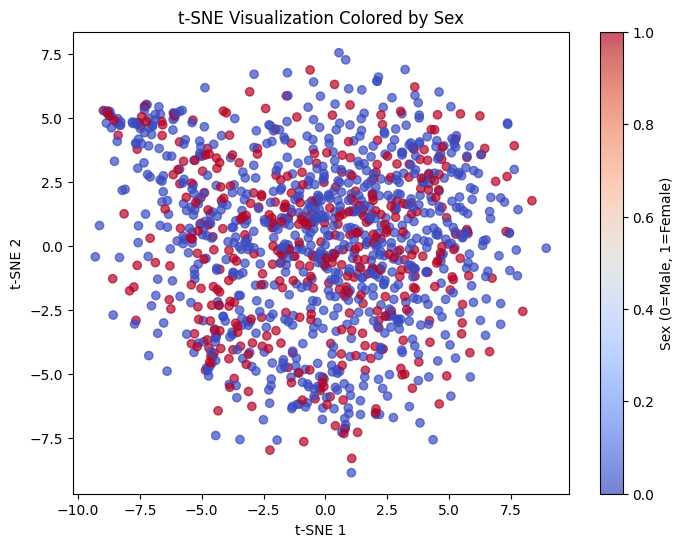

In [7]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_tsne = tsne.fit_transform(train_mri.drop(columns = ['participant_id']))

df_tsne = pd.DataFrame(reduced_tsne, columns=["TSNE1", "TSNE2"])
df_tsne["Sex_F"] = train_labels["Sex_F"]  # Ensure metadata is in the same order as fmri_matrix
df_tsne["ADHD_Outcome"] = train_labels["ADHD_Outcome"]

# Plot with color by sex_f
plt.figure(figsize=(8,6))
scatter = plt.scatter(df_tsne["TSNE1"], df_tsne["TSNE2"], c=df_tsne["Sex_F"], cmap="coolwarm", alpha=0.7)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Visualization Colored by Sex")
plt.colorbar(scatter, label="Sex (0=Male, 1=Female)")
plt.show()


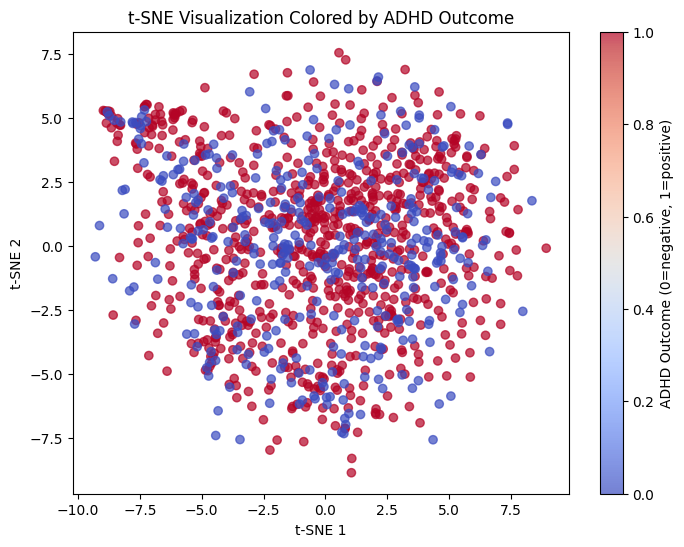

In [8]:
# Plot with color by sex_f
plt.figure(figsize=(8,6))
scatter = plt.scatter(df_tsne["TSNE1"], df_tsne["TSNE2"], c=df_tsne["ADHD_Outcome"], cmap="coolwarm", alpha=0.7)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Visualization Colored by ADHD Outcome")
plt.colorbar(scatter, label="ADHD Outcome (0=negative, 1=positive)")
plt.show()

In [52]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1000)  # Adjust based on variance explained
# reduced_data = pca.fit_transform(train_df.drop(columns = ['participant_id']))
reduced_data = pca.fit_transform(train_df_transformed)

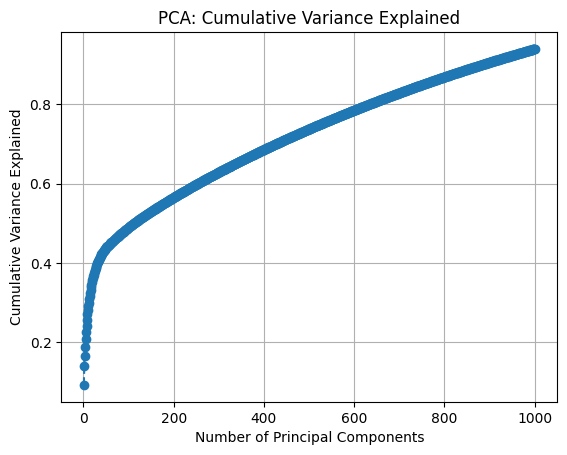

In [53]:
cumulative_variance = pca.explained_variance_ratio_.cumsum()

plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker="o", linestyle="--")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("PCA: Cumulative Variance Explained")
plt.grid()
plt.show()

### 4. Upsample Female

#### 4.1 Label distribution

In [29]:
train_df.groupby(['ADHD_Outcome', 'Sex_F'])['participant_id'].count().reset_index()

,ADHD_Outcome,Sex_F,participant_id
0,0,0,216
1,0,1,166
2,1,0,581
3,1,1,250


In [30]:
(train_df.groupby(['ADHD_Outcome']).participant_id.count()/len(train_df)).reset_index()

,ADHD_Outcome,participant_id
0,0,0.314922
1,1,0.685078


In [31]:
(train_df.groupby(['Sex_F']).participant_id.count()/len(train_df)).reset_index()

,Sex_F,participant_id
0,0,0.657049
1,1,0.342951


#### 4.2 Upsamling

In [78]:
X_smote = train_df_transformed[train_df_transformed.columns.difference(['Sex_F'])]
y_smote = train_df_transformed['Sex_F'].astype(int)


from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_upsampled, y_upsampled = smote.fit_resample(X_smote, y_smote)

In [79]:
# Convert back to DataFrame
X_upsampled = pd.DataFrame(X_upsampled, columns=X_smote.columns)
y_upsampled = pd.DataFrame(y_upsampled, columns=['Sex_F'])

# Reattach 'Sex_F' to the upsampled data
train_upsampled = pd.concat([X_upsampled, y_upsampled], axis=1)


## Modeling

### 1. All quant and qual features

In [34]:
# feature selection 
features = list(train_upsampled.columns.difference(target_columns))

In [35]:
features = [x for x in features if 'column' not in x]

In [42]:
def multi_output_f1(y_true, y_pred):
    # Ensure y_true and y_pred are NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # Compute accuracy for each target variable and return the mean
    return np.mean([f1_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])])

In [119]:
def weighted_f1_score(y_true, y_pred):
    # Ensure y_true and y_pred are NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # ADHD_Outcome column (index 1), Sex_F column (index 0)
    ADHD_Outcome = y_true[:, 1]
    Sex_F = y_true[:, 0]

    # Identify Female ADHD cases (where ADHD_Outcome=1 and Sex_F=1)
    female_adhd_mask = (ADHD_Outcome == 1) & (Sex_F == 1)

    # Compute F1-score for ADHD_Outcome (with 2x weight for Female ADHD cases)
    f1_adhd = f1_score(ADHD_Outcome, y_pred[:, 1], sample_weight=1 + female_adhd_mask)

    # Compute F1-score for Sex_F (with 2x weight for Female ADHD cases)
    f1_sex = f1_score(Sex_F, y_pred[:, 0], sample_weight=1 + female_adhd_mask)

    # Compute final score as the average of both F1-scores
    return (f1_adhd + f1_sex) / 2

In [113]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'estimator__alpha': [0, 0.1, 1, 10],  # L1 regularization
    'estimator__lambda': [0.1, 1, 10],  # L2 regularization
    'estimator__gamma': [0, 0.1, 0.5, 1]  # Tree pruning parameter
}


In [114]:
xgb_classifier = XGBClassifier(objective='binary:logistic', 
                               n_estimators=100, 
                               learning_rate=0.1, 
                               max_depth=6,
                               eval_metric='logloss')

multi_xgb = MultiOutputClassifier(xgb_classifier)

grid_search = GridSearchCV(multi_xgb, param_grid, scoring="f1_macro", cv=5, verbose=1, n_jobs=-1)


In [115]:
%%time
X_train_upsampled = train_upsampled[features]
y_train_upsampled = train_upsampled[target_columns].astype(int)

grid_search.fit(X_train_upsampled, y_train_upsampled)

# no upsampling
# X_train = train_df_transformed[train_df_transformed.columns.difference(target_columns)]
# y_train = train_df_transformed[target_columns]
# multioutput_classifier.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
CPU times: user 4.64 s, sys: 330 ms, total: 4.97 s
Wall time: 1min 22s


GridSearchCV(cv=5,
             estimator=MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                                     booster=None,
                                                                     callbacks=None,
                                                                     colsample_bylevel=None,
                                                                     colsample_bynode=None,
                                                                     colsample_bytree=None,
                                                                     device=None,
                                                                     early_stopping_rounds=None,
                                                                     enable_categorical=False,
                                                                     eval_metric='logloss',
                                                                     feature_types=None,
                                                                     gamma=None,
                                                                     grow_policy=None,
                                                                     importance_type=None,
                                                                     interaction...
                                                                     max_delta_step=None,
                                                                     max_depth=6,
                                                                     max_leaves=None,
                                                                     min_child_weight=None,
                                                                     missing=nan,
                                                                     monotone_constraints=None,
                                                                     multi_strategy=None,
                                                                     n_estimators=100,
                                                                     n_jobs=None,
                                                                     num_parallel_tree=None,
                                                                     random_state=None, ...)),
             n_jobs=-1,
             param_grid={'estimator__alpha': [0, 0.1, 1, 10],
                         'estimator__gamma': [0, 0.1, 0.5, 1],
                         'estimator__lambda': [0.1, 1, 10]},
             scoring='f1_macro', verbose=1)

In [118]:
grid_search.best_params_

{'estimator__alpha': 0, 'estimator__gamma': 0.1, 'estimator__lambda': 10}

In [94]:
xgb_tuned = grid_search.best_estimator_

<Axes: >

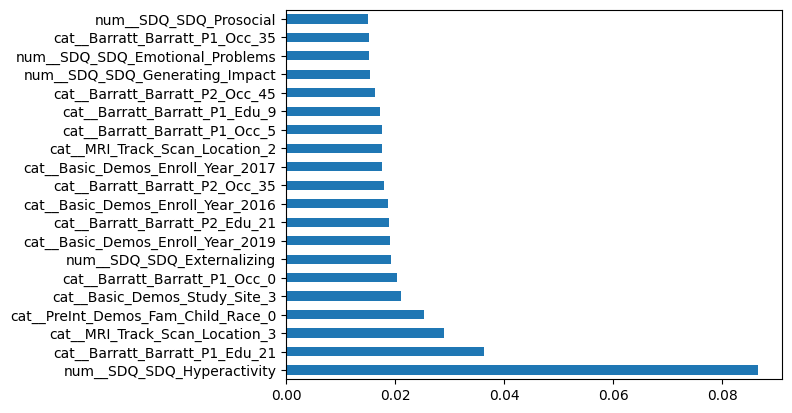

In [95]:
feat_impts = [] 
for clf in xgb_tuned.estimators_:
    feat_impts.append(clf.feature_importances_)

feat_importances = pd.Series(np.mean(feat_impts, axis = 0), index=X_train_upsampled.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [36]:
feat_importances.sort_values(ascending = False)

num__SDQ_SDQ_Hyperactivity            0.070279
cat__PreInt_Demos_Fam_Child_Race_0    0.033932
cat__Barratt_Barratt_P1_Edu_9         0.030921
cat__Basic_Demos_Enroll_Year_2018     0.023769
cat__Barratt_Barratt_P1_Edu_15        0.022847
                                        ...   
cat__Barratt_Barratt_P2_Edu_6         0.000000
cat__Barratt_Barratt_P2_Edu_3         0.000000
cat__Barratt_Barratt_P1_Occ_10        0.000000
cat__Barratt_Barratt_P1_Edu_6         0.000000
cat__Basic_Demos_Enroll_Year_2020     0.000000
Length: 83, dtype: float32

In [37]:
# Parent 2 level of education, Parent 1 level of education

<Axes: xlabel='Barratt_Barratt_P1_Edu', ylabel='count'>

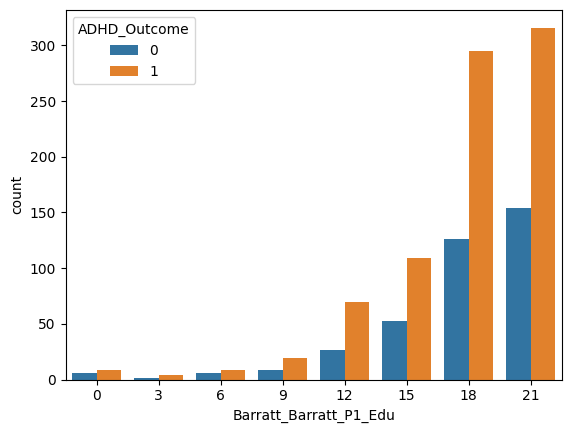

In [38]:
outcome_counts = train_df.groupby(['Barratt_Barratt_P1_Edu', 'ADHD_Outcome']).size().reset_index(name='count')
sns.barplot(x='Barratt_Barratt_P1_Edu', y='count', hue='ADHD_Outcome', data=outcome_counts)

In [39]:
#3=Less than 7th grade
train_df.groupby(['Barratt_Barratt_P1_Edu'])['ADHD_Outcome'].mean()

Barratt_Barratt_P1_Edu
0     0.600000
3     0.800000
6     0.600000
9     0.678571
12    0.721649
15    0.672840
18    0.700713
21    0.672340
Name: ADHD_Outcome, dtype: float64

### 2. Top 20 features

In [40]:
# top features
top_features = list(pd.DataFrame(feat_importances.nlargest(20)).index)

In [41]:
X_train_top_ft = train_upsampled[top_features]
y_train_top_ft = train_upsampled[target_columns].astype(int)

multioutput_classifier_top = MultiOutputClassifier(xgb_classifier)
multioutput_classifier_top.fit(X_train_top_ft, y_train_top_ft)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))

### 3. Logistic Regression

In [42]:
X_log = train_upsampled[features]
y_sex = train_upsampled['Sex_F'].astype(int)
y_adhd = train_upsampled['ADHD_Outcome'].astype(int)

In [43]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(penalty='l1',solver='liblinear', max_iter=1000)
lg_sex = lg.fit(X_log, y_sex)
lg_adhd = lg.fit(X_log, y_adhd)

In [44]:
cv_scores_sex = cross_val_score(lg_sex, X_log, y_sex, cv=5, scoring='f1')
cv_scores_adhd = cross_val_score(lg_adhd, X_log, y_adhd, cv=5, scoring='f1')

In [45]:
(np.mean(cv_scores_sex) + np.mean(cv_scores_adhd))/2

0.7311081193067699

In [46]:
coef_sex = lg_sex.coef_[0]  # Coefficients for Sex model
coef_adhd = lg_adhd.coef_[0]  # Coefficients for ADHD model

In [47]:
try:
    feature_names = X_log.columns  # If X_log is a DataFrame
except AttributeError:
    feature_names = [f"Feature {i}" for i in range(X_log.shape[1])] 

In [48]:
feature_sex = pd.concat([pd.Series(feature_names), pd.Series(coef_sex)], axis = 1)
feature_sex.columns = ['variable','coef']
feature_sex.sort_values(by = 'coef', ascending = False).head(20)

,variable,coef
54,cat__PreInt_Demos_Fam_Child_Ethnicity_3,1.337922
79,num__SDQ_SDQ_Hyperactivity,1.330110
77,num__SDQ_SDQ_Externalizing,0.770558
53,cat__PreInt_Demos_Fam_Child_Ethnicity_2,0.453786
81,num__SDQ_SDQ_Peer_Problems,0.422903
43,cat__Basic_Demos_Study_Site_2,0.378470
56,cat__PreInt_Demos_Fam_Child_Race_1,0.373436
61,cat__PreInt_Demos_Fam_Child_Race_4,0.353101
49,cat__MRI_Track_Scan_Location_3,0.302560
5,cat__Barratt_Barratt_P1_Edu_3,0.294611


In [49]:
feature_adhd = pd.concat([pd.Series(feature_names), pd.Series(coef_adhd)], axis = 1)
feature_adhd.columns = ['variable','coef']
feature_adhd.sort_values(by = 'coef', ascending = False).head(20)

,variable,coef
54,cat__PreInt_Demos_Fam_Child_Ethnicity_3,1.337922
79,num__SDQ_SDQ_Hyperactivity,1.330110
77,num__SDQ_SDQ_Externalizing,0.770558
53,cat__PreInt_Demos_Fam_Child_Ethnicity_2,0.453786
81,num__SDQ_SDQ_Peer_Problems,0.422903
43,cat__Basic_Demos_Study_Site_2,0.378470
56,cat__PreInt_Demos_Fam_Child_Race_1,0.373436
61,cat__PreInt_Demos_Fam_Child_Race_4,0.353101
49,cat__MRI_Track_Scan_Location_3,0.302560
5,cat__Barratt_Barratt_P1_Edu_3,0.294611


### 4. Ridge Classifier

In [24]:
alpha = 1.0  # Regularization strength (you can adjust this)
max_iter = 1000  # Maximum number of iterations for the solver to converge
solver = 'auto'  # Solver for optimization ('auto' chooses automatically)
ridge_classifier = RidgeClassifier(
    alpha=alpha, max_iter=max_iter, solver=solver,
    class_weight = "balanced")

In [25]:
multi_ridge = MultiOutputClassifier(ridge_classifier)

In [27]:
# all features
features = list(train_df_transformed.columns.difference(target_columns))
X_train = train_df_transformed[features]
y_train = train_df_transformed[target_columns].astype(int)


multi_ridge.fit(X_train, y_train)

MultiOutputClassifier(estimator=RidgeClassifier(class_weight='balanced',
                                                max_iter=1000))

Index(['cat__Barratt_Barratt_P1_Edu_0', 'cat__Barratt_Barratt_P1_Edu_12',
       'cat__Barratt_Barratt_P1_Edu_15', 'cat__Barratt_Barratt_P1_Edu_18',
       'cat__Barratt_Barratt_P1_Edu_21', 'cat__Barratt_Barratt_P1_Edu_3',
       'cat__Barratt_Barratt_P1_Edu_6', 'cat__Barratt_Barratt_P1_Edu_9',
       'cat__Barratt_Barratt_P1_Occ_0', 'cat__Barratt_Barratt_P1_Occ_10',
       ...
       'remainder__9throw_90thcolumn', 'remainder__9throw_91thcolumn',
       'remainder__9throw_92thcolumn', 'remainder__9throw_93thcolumn',
       'remainder__9throw_94thcolumn', 'remainder__9throw_95thcolumn',
       'remainder__9throw_96thcolumn', 'remainder__9throw_97thcolumn',
       'remainder__9throw_98thcolumn', 'remainder__9throw_99thcolumn'],
      dtype='object', length=19983)

In [42]:
feature_names = list(X_train.columns)
target_names = list(y_train.columns)
coef_dict = {target_names[i]: estimator.coef_.flatten() for i, estimator in enumerate(multi_ridge.estimators_)}

coef_df = pd.DataFrame(coef_dict, index=feature_names)

In [44]:
coef_df.sort_values(by='Sex_F', ascending = False).head(20)

,Sex_F,ADHD_Outcome
remainder__121throw_147thcolumn,0.163992,-0.010579
remainder__101throw_131thcolumn,0.163521,-0.029612
remainder__164throw_189thcolumn,0.152699,0.028589
remainder__91throw_157thcolumn,0.147009,-0.044943
remainder__34throw_65thcolumn,0.146797,-0.032342
remainder__50throw_53thcolumn,0.143583,-0.013065
remainder__53throw_55thcolumn,0.142890,0.022284
remainder__133throw_182thcolumn,0.137612,0.037554
remainder__40throw_65thcolumn,0.133808,0.058877
remainder__153throw_156thcolumn,0.132877,0.019048


In [45]:
coef_df.sort_values(by='ADHD_Outcome', ascending = False).head(20)

,Sex_F,ADHD_Outcome
num__SDQ_SDQ_Externalizing,-0.039385,0.280571
num__SDQ_SDQ_Hyperactivity,-0.108845,0.277174
remainder__8throw_96thcolumn,-0.000240,0.154095
num__SDQ_SDQ_Generating_Impact,0.058054,0.134392
remainder__52throw_60thcolumn,-0.005506,0.128556
remainder__53throw_83thcolumn,0.010311,0.122416
remainder__8throw_50thcolumn,-0.018258,0.121994
remainder__49throw_55thcolumn,0.005303,0.120116
remainder__162throw_190thcolumn,-0.149916,0.119672
remainder__30throw_55thcolumn,-0.013084,0.114268


### 6. Ridge Classifier Tuning

In [120]:
%%time

from sklearn.model_selection import GridSearchCV
param_grid = {'estimator__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
base_ridge = RidgeClassifier(class_weight='balanced')
multi_ridge = MultiOutputClassifier(base_ridge)

grid_search = GridSearchCV(multi_ridge, param_grid, 
                           scoring=make_scorer(weighted_f1_score),
                           cv=5)
grid_search.fit(X_train_upsampled, y_train_upsampled)

CPU times: user 1.92 s, sys: 4.98 ms, total: 1.93 s
Wall time: 979 ms


GridSearchCV(cv=5,
             estimator=MultiOutputClassifier(estimator=RidgeClassifier(class_weight='balanced')),
             param_grid={'estimator__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring=make_scorer(weighted_f1_score))

In [121]:
grid_search.best_params_

{'estimator__alpha': 1}

In [104]:
ridge_tuned = grid_search.best_estimator_

### 5. Ridge Classifier Top features

In [106]:
for estimator in ridge_model.estimators_:
    weights = pd.DataFrame(estimator.coef_.reshape(-1, 1), X_train_upsampled.columns, columns=['Coefficients'])

In [113]:
top_ft = list(weights.sort_values(by='Coefficients', ascending = False).head(20).index)

In [116]:
X_train_top_ft = train_upsampled[top_ft]
y_train_top_ft = train_upsampled[target_columns].astype(int)

ridge_top = MultiOutputClassifier(ridge_classifier)
ridge_top.fit(X_train_top_ft, y_train_top_ft)

MultiOutputClassifier(estimator=RidgeClassifier(max_iter=1000))

### Ridge Classifier PCA

In [57]:
alpha = 100  # Regularization strength (you can adjust this)
max_iter = 1000  # Maximum number of iterations for the solver to converge
solver = 'auto'  # Solver for optimization ('auto' chooses automatically)
ridge_classifier = RidgeClassifier(
    alpha=alpha, max_iter=max_iter, solver=solver,
    class_weight = "balanced")
ridge_pca = MultiOutputClassifier(make_pipeline(PCA(1000),
                                            ridge_classifier))

In [58]:
X_train = train_df_transformed[features]
y_train = train_df_transformed[target_columns].astype(int)


ridge_pca.fit(X_train, y_train)

MultiOutputClassifier(estimator=Pipeline(steps=[('pca', PCA(n_components=1000)),
                                                ('ridgeclassifier',
                                                 RidgeClassifier(alpha=100,
                                                                 class_weight='balanced',
                                                                 max_iter=1000))]))

### Cross Validataion

In [51]:
def cv_score(X_score, y_score, classifier_model, scorer):
    cv_scores = cross_val_score(classifier_model, X_score, y_score, cv=20, scoring=make_scorer(scorer))
    return cv_scores

In [100]:
%%time
# Perform cross-validation on the training data
cv_scores = {}
cvScore = cv_score(X_train_upsampled, y_train_upsampled, xgb_tuned, multi_output_f1)

# Output the cross-validation results
cv_scores['xgboost_all_unweighted'] = np.mean(cvScore)

cvScore_1 = cv_score(X_train_upsampled, y_train_upsampled, xgb_tuned, weighted_f1_score)
cv_scores['xgboost_all_weighted'] = np.mean(cvScore_1)

CPU times: user 2min 12s, sys: 791 ms, total: 2min 13s
Wall time: 34.2 s


In [129]:
%%time
# Perform cross-validation on the training data
cvScore = cv_score(X_train_upsampled, y_train_upsampled, multi_ridge, weighted_f1_score)
cv_scores['ridge_all_weighted'] = np.mean(cvScore)

cvScore_1 = cv_score(X_train_top_ft, y_train_top_ft, multi_ridge, weighted_f1_score)
cv_scores['ridge_all_weighted'] = np.mean(cvScore_1)

CPU times: user 56.7 s, sys: 373 ms, total: 57.1 s
Wall time: 15.6 s


In [130]:
%%time
# Perform cross-validation on the training data
cvScore = cv_score(X_train_top_ft, y_train_top_ft, ridge_top, multi_output_f1)
cvScore_1 = cv_score(X_train_top_ft, y_train_top_ft, ridge_top, weighted_f1_score)

cv_scores['ridge_top_unweighted'] = np.mean(cvScore)
cv_scores['ridge_top_weighted'] = np.mean(cvScore_1)

# multioutput_classifier_top

CPU times: user 1.14 s, sys: 6.06 ms, total: 1.14 s
Wall time: 739 ms


In [140]:
%%time
# Perform cross-validation on the training data
cvScore = cv_score(X_train_upsampled, y_train_upsampled, ridge_tuned, multi_output_f1)
cvScore_1 = cv_score(X_train_upsampled, y_train_upsampled, ridge_tuned, weighted_f1_score)

cv_scores['ridge_tuned_unweighted'] = np.mean(cvScore)
cv_scores['ridge_tuned_weighted'] = np.mean(cvScore_1)

CPU times: user 1.48 s, sys: 7.03 ms, total: 1.48 s
Wall time: 1.01 s


In [141]:
pd.DataFrame.from_dict(cv_scores, orient = 'index', columns = ['cv_score'])

,cv_score
xgboost_all_unweighted,0.718715
xgboost_top_unweighted,0.675204
xgboost_all_weighted,0.730900
xgboost_top_weighted,0.689926
ridge_top_unweighted,0.675204
ridge_top_weighted,0.689926
ridge_tuned_unweighted,0.706918
ridge_tuned_weighted,0.723549


## Evaluation

for the purposes of this competition we are assigning 2x weight to Female ADHD cases (ADHD_Outcome=1, Sex_F=1). In our implementation of the F1 Score

### 1.Transform test data

In [59]:
# set(X_train_upsampled.columns) - set(test_transformed_df.columns) - set(target_columns)
# set(test_transformed_df.columns) - set(X_train_upsampled.columns) 
best_model = ridge_pca
top_features = False

In [61]:
# reorder
# test_transformed_df = test_transformed_df[top_ft]
if top_features:
    X_test = test_transformed_df[top_ft]
else:
    X_test = test_transformed_df[X_train.columns]
y_pred = best_model.predict(X_test)

In [62]:
participant_id = test_df['participant_id']
predictions_df = pd.DataFrame(
    y_pred,
    columns=['Sex_F', 'ADHD_Outcome']
)

# Combine participant IDs with predictions
result_df = pd.concat([participant_id.reset_index(drop=True), predictions_df[['ADHD_Outcome', 'Sex_F']]], axis=1)

In [63]:
result_df.to_csv(f'submission_ridge_tuned_pca.csv', index=False)

print("Submission file created.")

Submission file created.


In [65]:
!head submission_nomri.csv

head: cannot open 'submission_nomri.csv' for reading: No such file or directory
